In [144]:
# Mudanças feitas nessa versão:
# - Análise feita por Houses;
# - Reorganização do código e adição de comentários;
# - Padronização de funções;
# - Criação de uma função para gerar os valores de EQMs;
# - Refatoração e melhoria do calculaDistancias, que agora é calculaEQM


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [146]:
# Bloco de Funções para leitura de dados

# O formato dos dados em "DT_EVENTO" é diferente daquele nos nomes das leituras
# Portanto, a função eventTimeConverter realiza essa conversão para auxiliar no tratamento dos dados
def eventTimeConverter(DataFrame, tamanhoBase):
    dtEvento = []
    for i in range(0, tamanhoBase):
        aux = DataFrame.iloc[i, 4].replace(' ', '_')
        aux = aux.replace('-', '')
        dtEvento.append(aux.replace(':', ''))
        
    return dtEvento

# Os dados das leituras estão em arquivos txt, logo, seu tipo é string
# Para poder realizar a manipulação dos mesmos, realiza-se a conversão por meio 
# da função stringToFloat
def stringToFloat(dataFrame, nome):
    dataFrame[nome] = pd.to_numeric(dataFrame[nome], downcast="float")

    
# A função getDados obtém os valores de corrente RMS nos txts já formatados
def getDados(Leitura, tipoDeDado):
    f = open(Leitura) # pode ser adicionado o .txt, mas ele ja esta presente nas colunas
    lines = f.readlines()
    i = 0
    while(i < len(lines)):
        i += 1
        if(lines[i] == "***End_of_Header***\n"):
            break
    
    Inicio = i + 2
    with open(Leitura) as f:
        linhas = f.readlines()[Inicio:]
    df = pd.DataFrame(linhas)
    df = df[0].str.split('\t', expand=True)
    stringToFloat(df, 2)
    
    if(tipoDeDado == 'tempo'):
        return np.array(df[0])
    if(tipoDeDado == 'corrente'):
        return np.array(df[1])
    if(tipoDeDado == 'correnteRMS'):
        return np.array(df[2])

# A função getLeituras obtém os valores de corrente RMS para cada leitura da house em análise
def getLeituras(maquinas, amostragem, maquinaAnalisada):
    for i in range(0, int(len(maquinas.index))):  
        try:
            leitura = getDados(maquinas['DS_LOCAL_INSTALACAO'].iloc[i] + '/' + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt', 'correnteRMS')
        except FileNotFoundError:
            print("Leitura não encontrada: " + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt')
        else:
            DF = pd.DataFrame(leitura, columns=[maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i]])
            stringToFloat(DF, maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i])
            DF = DF.transpose()
            maquinaAnalisada = pd.concat([maquinaAnalisada, DF,])
    maquinaAnalisada = maquinaAnalisada.transpose()
        
    return maquinaAnalisada

In [147]:
# Bloco de Funções para correção de dados

# Os inícios da Fase 1 não são padronizados, podendo começar em instantes diferentes
# Se o filtro não é utilizado, as curvas médias apresentam um comportamento bizarro, as médias não consideram deslocamento
def filtroLeituraDeslocada(leituras, dfPontosFase):
    leiturasFiltradas = []
    if(dfPontosFase.iloc[0,0] != None):
        min = dfPontosFase.iloc[0,0]
        for i in range(0, len(dfPontosFase.columns)):
            if(min > dfPontosFase.iloc[0, i]):
                min = dfPontosFase.iloc[0, i]
        
        for i in range(0, len(dfPontosFase.columns)):
            if(dfPontosFase.iloc[0, i] > 1.5*min):
                leiturasFiltradas.append(dfPontosFase.columns[i])

        leituras = leituras.drop(leiturasFiltradas, axis=1)
    else:
        print('Nao há leituras normais')
    return leituras

# Algumas leituras apresentam comportamento ruidoso, com correntes no intervalo [0,1]
# Para evitar que isso atrapalhe os cálculos e resultados, utiliza-se o filtro abaixo
# EXEMPLO DE LEITURA EM QUE ISSO ACONTECE: MCH004W21A_R_20190906_104250
def filtroLeiturasRuido(Maquinas):
    max = 0
    leiturasRuido = []
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 1):
            leiturasRuido.append(Maquinas.columns[i])
        max = 0
    
    Maquinas = Maquinas.drop(leiturasRuido, axis=1)
    return Maquinas  

# Leituras realizadas no período entre Agosto e Outubro sofreram uma atenuação por um filtro
# aplicado pela Vale, para tratar os dados corretamente, é necessário corrigir os valores de 
# corrente dessas leituras
def corrigeCorrentes(Maquinas, fatorDeCorrecao):
    max = 0
    aux = 0
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 12):
            Maquinas[Maquinas.columns[i]] = fatorDeCorrecao*Maquinas[Maquinas.columns[i]]
        max = 0
    
    return Maquinas

In [148]:
# Bloco de Funções para cálculos feitos com dados

def Derivada(valor, intervalo):
    derivada = np.diff(valor.values)/intervalo    #pode ser alterado pra utilizar a coluna do tempo ao inves de um intervalo 
    return derivada
    pd.set_option('display.max_rows', 300)

# Determina os fins de fase de uma leitura ou assinatura
def calculaFases(corrente, intervalo):
    deriv = np.array(Derivada(corrente, intervalo))
    corrente = np.array(corrente)
    fimFases = []
    fimFase0 = np.argmax(deriv[50:]>10) + 50
    fimFases.append(fimFase0)
    topo = 0
    topo = np.argmax(deriv[fimFase0:]<0)
    topo = topo + fimFase0
     
    metadeCorrente = np.argmax(corrente[topo:]<(corrente[topo]/2))  + topo
    fimFase1 = np.argmax(deriv[metadeCorrente + 1:]>-4)
    fimFase1 = fimFase1 + metadeCorrente + int(0.04545/intervalo)
    fimFases.append(fimFase1)
    #
    #descomentar quado se tratar de leituras novas
    #result = np.where(deriv[fimFase1 + int(0.15/intervalo):] == np.amin(deriv[fimFase1 + int(0.15/intervalo):fimFase1 + int(0.5/intervalo)]))
    #fimFase2 = result[0][0] + int(0.04/intervalo) + fimFase1 + int(0.15/intervalo)
    #fimFases.append(fimFase2)
    result = np.where(deriv == np.amax(deriv[fimFase1 + int(0.9/intervalo):fimFase1 + int(2/intervalo)]))
    fimFase3 = result[0][0] - int(0.04040/intervalo)
    fimFases.append(fimFase3)
    
    fimCorrente = np.argmax(corrente[fimFase3:]<(corrente[topo]/20)) + fimFase3
    fimFase4 = np.argmax(deriv[fimCorrente + 1:] > -1)
    fimFase4 = fimCorrente + fimFase4 - int(0.02020/intervalo)
    fimFases.append(fimFase4)
    return (fimFases)

# A função geraAssinaturaMedia plota um gráfico com as curvas mínima, média e máxima para leituras de uma house
def geraAssinaturaMedia(maquinaEmAnalise, parametroStd):
    assinaturaNormal = pd.DataFrame()
    dfex = maquinaEmAnalise
    assinaturaNormal = assinaturaNormal.assign(Tempo = lambda x: dfex['t (s)']) 
    dfex = dfex.drop("t (s)", axis=1)
    stdNormal = dfex.std(axis=1)
    mediaNormal = dfex.mean(axis=1)
    assinaturaNormal['Std'] = stdNormal
    assinaturaNormal['Média'] = mediaNormal
    assinaturaNormal['Curva mínima'] = mediaNormal - parametroStd*stdNormal
    assinaturaNormal['Curva máxima'] = mediaNormal + parametroStd*stdNormal
    dfex.shape
    for i in range(0, len(assinaturaNormal.index)):
        if(assinaturaNormal.iloc[i, 3] < 0):
            assinaturaNormal.iloc[i, 3] = 0
      
    return assinaturaNormal

def subtraiMedia(leituras, inicio, final, media, distanciaFases, i):
    dist = total = 0
    for j in range(inicio, final):
        dist += (leituras.iloc[j, i] - media)**2
        if(j == final-1):
            distanciaFases.append(dist/(final))
            total += dist
            dist = 0
    return total

def eqmPorFase(leituras, dfPontosFase, dist, fase, pontosMedia, col, i):
    fragNormal = normal['Média'][int(pontosMedia['Fim da Fase ' + str(int(fase) - 1)]):int(pontosMedia['Fim da Fase ' + fase])]
    fragNormal.to_numpy()
    fragLeitura = leituras[col][dfPontosFase.iloc[0, i-1]: dfPontosFase.iloc[0, i-1]+(int(pontosMedia['Fim da Fase '+ fase])-int(pontosMedia['Fim da Fase 0']))]
    fragLeitura.to_numpy()
    subtraction = np.subtract(fragNormal, fragLeitura)
    power = np.power(subtraction,2)
    dist += np.sum(power, axis=0)
    return dist

def calculaEQM (normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0
    i = 1
    
    for col in leituras.columns:
        if(col != 't (s)'):
            total += subtraiMedia(leituras, 0, dfPontosFase.iloc[0, i-1], mediaInicio, distanciaFases, i)

            for k in range(1, 4):
                dist = eqmPorFase(leituras, dfPontosFase, dist, str(k), pontosMedia, col, i)
                distanciaFases.append(dist/(int(pontosMedia['Fim da Fase '+ str(k)])-int(pontosMedia['Fim da Fase ' + str(k - 1)])))
                total += dist
                dist = 0

            total += subtraiMedia(leituras, dfPontosFase.iloc[3, i-1], len(leituras.index), mediaFim, distanciaFases, i)

            distanciaFases.append(total/amostragem)
            total = 0

            DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
            DF = DF.transpose()
            distanciaFases = []
            distanciasDF = pd.concat([distanciasDF, DF,])
            i += 1

    distanciasDF = distanciasDF.transpose()
    return distanciasDF

def geraTabelaEQM(mediaTotal, stdTotal):
    valores = []
    valores.append(mediaTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] - stdTotal.iloc[0])
    valores.append(mediaTotal.iloc[0] + stdTotal.iloc[0])
    valoresDF = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase 0'])
    valoresDF = valoresDF.transpose()
    valores = []
    for i in range(1, 6):
        valores.append(mediaTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] - stdTotal.iloc[i])
        valores.append(mediaTotal.iloc[i] + stdTotal.iloc[i])
        if(i < 5):
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Fase ' + str(i)])
        else:
            valoresAux = pd.DataFrame(valores, index=['Média','Mínima','Máxima'], columns=['EQM Normal Total'])
        valores = []
        valoresAux = valoresAux.transpose()
        valoresDF = pd.concat([valoresDF, valoresAux, ])
    return valoresDF

In [149]:
%%time
pd.options.display.max_rows = 8200
pd.options.display.max_columns = 4000

amostragem = 8182 # número de pontos em cada amostra
tamanhoBase = 6966 # número de leituras classificadas disponíveis na base
house = 'H008' # house em análise

baseDF = pd.read_csv('BASE_TREINAMENTO.csv', sep=",")
dt = eventTimeConverter(baseDF, tamanhoBase) # corrige o formato das datas para igualar àqueles dos txts
dtEvento = pd.DataFrame(dt, columns=['DT_EVENTO'])
baseDF = baseDF.assign(DT_EVENTO=dtEvento['DT_EVENTO'])
maquinas = baseDF.loc[(baseDF["DS_LOCAL_INSTALACAO"] == house)]
#maquinas.to_csv(house + '.csv')

dt = getDados('H004/MCH004W21A_N_20190817_190721.txt', 'tempo') # eixo x (pode ser qualquer leitura)
maquinaAnalisada = pd.DataFrame(dt, columns=['t (s)']) 
stringToFloat(maquinaAnalisada, 't (s)')
maquinaAnalisada = maquinaAnalisada.transpose()

CPU times: user 138 ms, sys: 9.4 ms, total: 147 ms
Wall time: 146 ms


In [150]:
%%time
# separação por estado da máquina
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

# obtenção dos valores de corrente para cada leitura em cada classificação
maquinasPorEstado = []
maquinasPorEstado.append(getLeituras(maquinasSemDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasFalha, amostragem, maquinaAnalisada))

CPU times: user 18.9 s, sys: 317 ms, total: 19.2 s
Wall time: 19.3 s


In [151]:
%%time
# filtra leituras ruidosas
for i in range(0,3):  
    maquinasPorEstado[i] = filtroLeiturasRuido(maquinasPorEstado[i])
    
# corrige leituras atenuadas entre agosto e outubro (se houver)
fatorDeCorrecao = 1.52 # o fator de correçao ainda é um valor estimado, não foi um dado fornecido pela Vale
for i in range(0,3):  
    maquinasPorEstado[i] = corrigeCorrentes(maquinasPorEstado[i], fatorDeCorrecao)

CPU times: user 1min 21s, sys: 149 ms, total: 1min 22s
Wall time: 1min 22s


In [152]:
%%time
PontosFase = []
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for rotulo in range(0, 3):
    for col in maquinasPorEstado[rotulo]:
        if (col != 't (s)'):
            pontos = calculaFases(maquinasPorEstado[rotulo][col], 0.00101)
            dfPontosFase[col] = pontos
    PontosFase.append(dfPontosFase)
    dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

CPU times: user 414 ms, sys: 3.22 ms, total: 417 ms
Wall time: 417 ms


In [153]:
def plotaMarcado(corrente, fimDeFase, Leitura):
    corrente.plot(kind='line')
    plt.annotate('fim da fase 0', xy=(fimDeFase[0], corrente.iloc[fimDeFase[0]]), xytext=(1000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 1', xy=(fimDeFase[1], corrente.iloc[fimDeFase[1]]), xytext=(1100, 2.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    #plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(1300, 5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(4000, 7), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 3', xy=(fimDeFase[3], corrente.iloc[fimDeFase[3]]), xytext=(6000, 2), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.title(Leitura)
    plt.show()

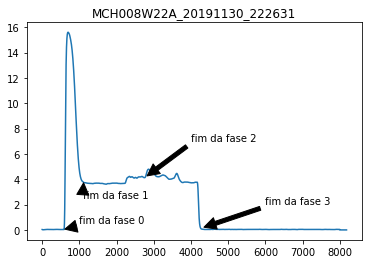

In [154]:
leitura = 'MCH008W22A_20191130_222631'
plotaMarcado(maquinasPorEstado[0][leitura], PontosFase[0][leitura], leitura)

CPU times: user 250 ms, sys: 2.28 ms, total: 253 ms
Wall time: 252 ms


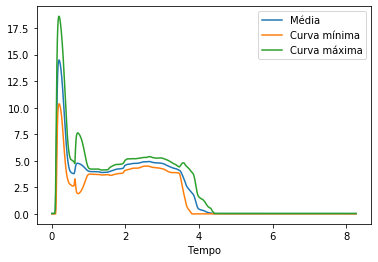

In [155]:
%%time
# SELECIONA DADOS E PLOTA O GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
parametroStd = 1
normal = geraAssinaturaMedia(maquinasPorEstado[0], parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

CPU times: user 239 ms, sys: 3.38 ms, total: 242 ms
Wall time: 240 ms


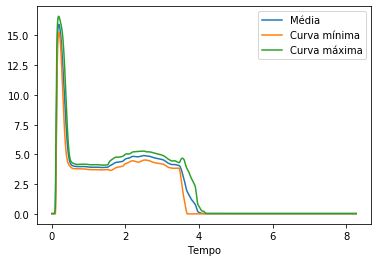

In [156]:
%%time
# MEDIA NORMAL COM FILTRO DE LEITURAS DESLOCADAS
normaisDeslocamentoFiltrado = filtroLeituraDeslocada(maquinasPorEstado[0], PontosFase[0])
parametroStd = 1
normal = geraAssinaturaMedia(normaisDeslocamentoFiltrado, parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

In [157]:
%%time
# CALCULA MEDIA DOS FINS DE CADA FASE PARA LEITURA NORMAL FILTRADA
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for col in normaisDeslocamentoFiltrado:
    if (col != 't (s)'):
        pontos = calculaFases(normaisDeslocamentoFiltrado[col], 0.00101)
        dfPontosFase[col] = pontos

#calcula os pontos de troca de fase da assinatura
pontosMediaFilt = dfPontosFase.mean(axis=1)
print (pontosMediaFilt)

# Esse bloco calcula uma media dos valores normais para a fase inicial para ser comparada com as leituras em
# analise, a escolha desse metodo serve para contornar os casos em que o inicio da fase 1 esta deslocado.
mediaInicio = mediaFim = 0

for c in range(0, int(pontosMediaFilt.iloc[0])):
    mediaInicio += normal.iloc[c, 2]
mediaInicio = mediaInicio/int(pontosMediaFilt.iloc[0])
    
# Esse bloco e analogo ao primeiro, fazendo o mesmo processo mas para a fase final
for d in range(int(pontosMediaFilt.iloc[3]), amostragem):
    mediaFim += normal.iloc[d, 2]
mediaFim = mediaFim/int(pontosMediaFilt.iloc[3])

Fim da Fase 0      92.400000
Fim da Fase 1     539.320635
Fim da Fase 2    1728.469841
Fim da Fase 3    3729.053968
dtype: float64
CPU times: user 196 ms, sys: 1.91 ms, total: 198 ms
Wall time: 197 ms


In [65]:
%%time
# Trecho que gera o csv com os valores normais de corrente da house analisada
normal.to_csv('normal'+ house + '.csv')

# Trecho que gera o csv com os valores de pontos médio para cada fim de fase da assinatura normal
pontosMediaFilt.to_csv('pontosMedia'+ house + '.csv')

NameError: name 'fabricante' is not defined

In [158]:
PontosFase[0]

,MCH008W21A_20190805_110550,MCH008W21A_20190805_111727,MCH008W21A_20190821_100342,MCH008W21A_20190821_133904,MCH008W21A_20190821_145521,MCH008W21A_20190821_190223,MCH008W21A_20190822_143428,MCH008W21A_20190822_160251,MCH008W21A_20190823_102739,MCH008W21A_20190823_113255,MCH008W21A_20190823_125305,MCH008W21A_20190823_141950,MCH008W21A_20190823_164231,MCH008W21A_20190823_191627,MCH008W21A_20190823_213107,MCH008W21A_20190823_224353,MCH008W21A_20190824_013729,MCH008W21A_20190824_041607,MCH008W21A_20190824_054735,MCH008W21A_20190824_084458,MCH008W21A_20190824_111507,MCH008W21A_20190824_115045,MCH008W21A_20190824_141910,MCH008W21A_20190825_104538,MCH008W21A_20190825_121451,MCH008W21A_20190825_203849,MCH008W21A_20190825_215236,MCH008W21A_20190825_230245,MCH008W21A_20190826_005613,MCH008W21A_20190805_110031,MCH008W21A_20190805_111252,MCH008W21A_20190821_092214,MCH008W21A_20190821_121047,MCH008W21A_20190821_140603,MCH008W21A_20190821_150957,MCH008W21A_20190821_184519,MCH008W21A_20190822_140514,MCH008W21A_20190822_160008,MCH008W21A_20190822_174129,MCH008W21A_20190823_100221,MCH008W21A_20190823_111022,MCH008W21A_20190823_122535,MCH008W21A_20190823_141442,MCH008W21A_20190823_162656,MCH008W21A_20190823_174706,MCH008W21A_20190823_202506,MCH008W21A_20190823_214432,MCH008W21A_20190824_032952,MCH008W21A_20190824_054018,MCH008W21A_20190824_081014,MCH008W21A_20190824_104058,MCH008W21A_20190824_112555,MCH008W21A_20190824_131103,MCH008W21A_20190824_233653,MCH008W21A_20190825_103915,MCH008W21A_20190825_114950,MCH008W21A_20190825_202654,MCH008W21A_20190825_214705,MCH008W21A_20190825_224511,MCH008W21A_20190826_003101,MCH008W21B_20190805_110550,MCH008W21B_20190805_111727,MCH008W21B_20190821_100342,MCH008W21B_20190821_133904,MCH008W21B_20190821_145521,MCH008W21B_20190821_155740,MCH008W21B_20190821_190224,MCH008W21B_20190822_143428,MCH008W21B_20190822_160251,MCH008W21B_20190822_175133,MCH008W21B_20190823_102739,MCH008W21B_20190823_113255,MCH008W21B_20190823_125305,MCH008W21B_20190823_141950,MCH008W21B_20190823_164231,MCH008W21B_20190823_191627,MCH008W21B_20190823_213107,MCH008W21B_20190823_224353,MCH008W21B_20190824_013729,MCH008W21B_20190824_054734,MCH008W21B_20190824_115045,MCH008W21B_20190824_141910,MCH008W21B_20190824_235220,MCH008W21B_20190825_104538,MCH008W21B_20190825_121451,MCH008W21B_20190825_203849,MCH008W21B_20190825_215236,MCH008W21B_20190821_092214,MCH008W21B_20190821_121047,MCH008W21B_20190821_140603,MCH008W21B_20190821_184519,MCH008W21B_20190823_100221,MCH008W21B_20190823_111022,MCH008W21B_20190823_122535,MCH008W21B_20190823_141442,MCH008W21B_20190823_162656,MCH008W21B_20190823_174706,MCH008W21B_20190823_202506,MCH008W21B_20190823_214432,MCH008W21B_20190824_012528,MCH008W21B_20190824_032952,MCH008W21B_20190824_054018,MCH008W21B_20190824_081013,MCH008W21B_20190824_104058,MCH008W21B_20190824_112555,MCH008W21B_20190824_131103,MCH008W22A_20190805_042956,MCH008W22A_20190805_052949,MCH008W22A_20190805_055128,MCH008W22A_20190805_062304,MCH008W22A_20190805_080509,MCH008W22A_20190805_090600,MCH008W22A_20190821_103424,MCH008W22A_20190821_161250,MCH008W22A_20190821_203334,MCH008W22A_20190822_024057,MCH008W22A_20190822_074757,MCH008W22A_20190822_085722,MCH008W22A_20190822_114401,MCH008W22A_20190822_152734,MCH008W22A_20190822_233029,MCH008W22A_20190823_022802,MCH008W22A_20190823_035256,MCH008W22A_20190823_081025,MCH008W22A_20190824_112555,MCH008W22A_20190824_153915,MCH008W22A_20190824_195454,MCH008W22A_20190824_233653,MCH008W22A_20190825_004927,MCH008W22A_20190825_014531,MCH008W22A_20190825_030237,MCH008W22A_20190825_065102,MCH008W22A_20190825_090707,MCH008W22A_20190825_150328,MCH008W22A_20190825_171107,MCH008W22A_20190825_191702,MCH008W22A_20190825_214705,MCH008W22A_20190825_224511,MCH008W22A_20190805_053858,MCH008W22A_20190805_061038,MCH008W22A_20190805_065148,MCH008W22A_20190805_083713,MCH008W22A_20190806_101811,MCH008W22A_20190812_021956,MCH008W22A_20190821_061234,MCH008W22A_20190821_102731,MCH008W22A_20190821_160049,MCH008W22A_20190821_195930,MCH

In [159]:
%%time
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS NORMAIS
distanciasNormais = calculaEQM(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasNormais = distanciasNormais.transpose()
mediaTotalNormal= distanciasNormais.mean(axis=0)
stdTotalNormal= distanciasNormais.std(axis=0)
distanciasNormais['rotulo'] = 0
distanciasNormais

CPU times: user 24.3 s, sys: 42.5 ms, total: 24.3 s
Wall time: 24.4 s


,EQM Fase 0,EQM Fase 1,EQM Fase 2,EQM Fase 3,EQM Fase 4,EQM Total,rotulo
MCH008W21A_20190805_110550,0.000026,2.764614,0.070738,0.639293,0.001441,0.319104,0
MCH008W21A_20190805_111727,0.000056,2.582939,0.053916,0.611904,0.001378,0.299973,0
MCH008W21A_20190821_100342,0.000009,3.247746,0.034635,0.602398,0.001452,0.331240,0
MCH008W21A_20190821_133904,0.000102,3.678908,0.028706,0.582483,0.001467,0.349079,0
MCH008W21A_20190821_145521,0.000038,4.168718,0.033850,0.654947,0.001440,0.394280,0
MCH008W21A_20190821_190223,0.000017,2.822161,0.036219,0.606326,0.001486,0.309214,0
MCH008W21A_20190822_143428,0.000010,3.309227,0.032079,0.613363,0.001437,0.336894,0
MCH008W21A_20190822_160251,0.000037,2.961266,0.037541,0.624667,0.001495,0.321501,0
MCH008W21A_20190823_102739,0.000056,2.542205,0.034870,0.632776,0.001384,0.300090,0
MCH008W21A_20190823_113255,0.000059,2.563974,0.033087,0.634978,0.001442,0.301617,0


In [31]:
valoresNormais = geraTabelaEQM(mediaTotalNormal, stdTotalNormal)
valoresNormais

,Média,Mínima,Máxima
EQM Normal Fase 0,0.385586,-0.578533,1.349706
EQM Normal Fase 1,5.409953,5.105842,5.714064
EQM Normal Fase 2,0.736588,0.583231,0.889945
EQM Normal Fase 3,0.269540,0.165931,0.373149
EQM Normal Fase 4,0.496835,0.307063,0.686607
EQM Normal Total,0.793153,0.703722,0.882584


In [67]:
%%time
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS DEFEITUOSAS
distanciasDefeito = calculaEQM(normal, maquinasPorEstado[1], PontosFase[1], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasDefeito = distanciasDefeito.transpose()
mediaTotalDefeito= distanciasDefeito.mean(axis=0)
stdTotalDefeito= distanciasDefeito.std(axis=0)
distanciasDefeito['rotulo'] = 1
distanciasDefeito

CPU times: user 11.4 s, sys: 9.74 ms, total: 11.4 s
Wall time: 11.4 s


,EQM Fase 0,EQM Fase 1,EQM Fase 2,EQM Fase 3,EQM Fase 4,EQM Total,rotulo
MCH006W21A_20190821_095829,0.011835,0.942796,0.010505,2.349746,0.037183,0.670190,1
MCH006W21A_20190821_161953,0.011822,1.818184,0.012715,3.017166,0.010833,0.881816,1
MCH006W21A_20190821_180915,0.011822,1.157008,0.007489,2.704298,0.015076,0.749566,1
MCH006W21A_20190821_224037,0.011835,0.955823,0.020657,1.815567,0.102287,0.615783,1
MCH006W21A_20190822_005944,0.011835,0.974512,0.013858,2.252281,0.059964,0.674286,1
MCH006W21A_20190822_024519,0.011679,1.576702,0.014894,2.449759,0.036370,0.754151,1
MCH006W21A_20190822_044624,0.011804,0.769131,0.011527,2.113507,0.087912,0.650134,1
MCH006W21A_20190822_090553,0.011835,1.162146,0.005273,2.727224,0.016943,0.756750,1
MCH006W21A_20190822_094518,0.011835,1.147964,0.004568,1.997833,0.066748,0.637368,1
MCH006W21A_20190822_103016,0.013153,1.690127,0.003163,2.384674,0.026547,0.737922,1


In [34]:
valoresDefeito = geraTabelaEQM(mediaTotalDefeito, stdTotalDefeito)
valoresDefeito

In [ ]:
# BLOCO DE ANALISE DE DISTANCIAS PARA LEITURAS COM FALHA
distanciasFalha = calculaEQM(normal, maquinasPorEstado[2], PontosFase[2], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
distanciasFalha = distanciasFalha.transpose()
mediaTotalFalha= distanciasFalha.mean(axis=0)
stdTotalFalha= distanciasFalha.std(axis=0)

distanciasFalha

In [ ]:
valoresFalha = geraTabelaEQM(mediaTotalFalha, stdTotalFalha)
valoresFalha

In [ ]:
#valoresNormais = pd.concat([valoresNormais, valoresDefeito,])
#valoresNormais = pd.concat([valoresNormais, valoresFalha,])

# Gera o csv com os parâmetros de eqm
#valoresNormais.to_csv('eqmTreinamento'+ fabricante + '.csv')

In [ ]:
#junta os dataframes de normal e defeito
principal = pd.concat([distanciasNormais, distanciasDefeito])
principal

In [ ]:
#divide em dataframe de treino e teste
from sklearn.model_selection import train_test_split
train, test = train_test_split(principal, random_state=0)

In [ ]:
#configura as features a ser analisadas, e treina o modelo
from sklearn.linear_model import LogisticRegression
feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4']
X_treino = train.loc[:, feature_cols]
y_treino = train.rotulo
X_teste = test.loc[:, feature_cols]
y_teste = test.rotulo
modelo = LogisticRegression()
modelo.fit(X_treino, y_treino)

In [ ]:
#testa a acuracia na base de treino e teste
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(modelo.score(X_treino, y_treino)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(modelo.score(X_teste, y_teste)))

In [ ]:
X_treino.shape

In [ ]:
predictions = modelo.predict_proba(X_teste)
predictions

In [ ]:
y_teste

In [ ]:
modelo.get_params()

In [ ]:
print (modelo.coef_)

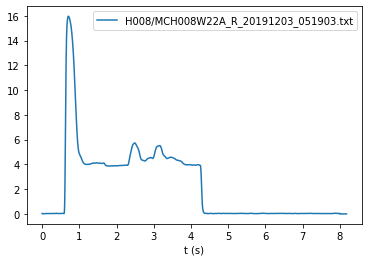

In [135]:
# Plotagem de leituras individuais para análise
house = 'H008' #MCH008W22A_20191130_222631 MCH008W22A_20191203_051903
tipoDeMaquina = 'MCH008W22A'
configuracao = 'R'
leitura = '20191203_051903'

Leitura = house + '/' + tipoDeMaquina + '_' + configuracao + '_' + leitura + '.txt'
dt = getDados('H006/MCH006W22B_N_20191014_132901.txt', 'tempo')
selecionadas = pd.DataFrame()
selecionadas['t (s)'] = dt
stringToFloat(selecionadas, 't (s)')
selecionadas = selecionadas.transpose()
leituras = getDados(Leitura, 'correnteRMS')
DF = pd.DataFrame(leituras, columns=[Leitura])
stringToFloat(DF, Leitura)

max = 0
for j in range(0, len(DF.index)):
    if(max <= DF.iloc[j, 0]):
        max = DF.iloc[j, 0]
    
if(max < 12):
    for j in range(0, len(DF.index)):
        aux = DF.iloc[j, 0]
        DF.iloc[j, 0] = aux*fatorDeCorrecao

DF = DF.transpose()
selecionadas = pd.concat([selecionadas, DF,])
selecionadas = selecionadas.transpose()

ax = plt.gca()
selecionadas.plot(kind='line',x='t (s)',y=Leitura,ax=ax)